https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia 
x-ray data 폐렴 구분 AI 모델
2.2 : NOMAL, PNEUMONIA 2진분류 => NOMAL, VIRAL PNEUMONIA, VACTERIAL PNEUMONIA

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6847038315138450995
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4975187744
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10943671604087197366
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG16

import pandas as pd
import seaborn as sns
import numpy as np


In [11]:
train_data_dir = 'C:/Users/s_wnsgk4041/data/2.2/train'
validation_data_dir = 'C:/Users/s_wnsgk4041/data/2.2/val'
test_data_dir = 'C:/Users/s_wnsgk4041/data/2.2/test'

nb_train_samples = len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/train/NORMAL/')) + len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/train/VIRAL/')) + len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/train/BACTERIAL/'))
nb_validation_samples = len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/val/NORMAL/')) + len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/val/VIRAL/')) + len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/val/BACTERIAL/'))
print(nb_train_samples)
print(nb_validation_samples)

4762
472


[1201, 1198, 2363]


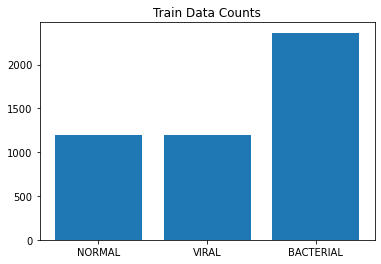

In [12]:
label = ['NORMAL','VIRAL', 'BACTERIAL']

train_counts = [len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/train/NORMAL/')), len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/train/VIRAL/')), len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/train/BACTERIAL/'))]
print(train_counts)

plt.bar(label, train_counts)
plt.title('Train Data Counts')
plt.show()

[148, 149, 175]


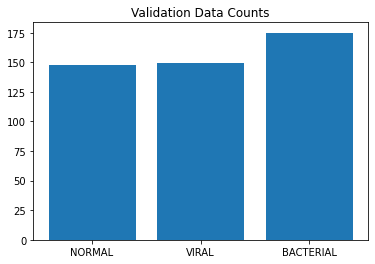

In [13]:
val_counts = [len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/val/NORMAL/')), len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/val/VIRAL/')), len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/val/BACTERIAL/'))]
print(val_counts)


plt.bar(label, val_counts)
plt.title('Validation Data Counts')
plt.show()

[234, 148, 242]


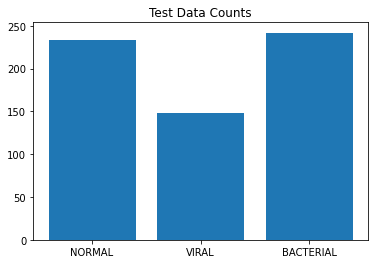

In [14]:
test_counts = [len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/test/NORMAL/')), len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/test/VIRAL/')), len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/test/BACTERIAL/'))]
print(test_counts)

plt.bar(label, test_counts)
plt.title('Test Data Counts')
plt.show()

In [15]:
img_width = 250
img_height = 300
img_channel = 3

In [17]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape = (img_height, img_width, img_channel))

In [18]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 250, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 62, 128)       0     

In [19]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.4)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.4)(x)
predictions = Dense(3, activation='softmax')(x)

In [20]:
model = Model(inputs=base_model.input, outputs=predictions)

In [21]:
len(model.layers)

27

In [22]:
len(base_model.layers)

19

In [23]:
for i in range(len(model.layers)):
    if i < len(base_model.layers):
        model.layers[i].trainable = False

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 250, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 62, 128)       0     

In [26]:
model.compile(
    loss='categorical_crossentropy',
    optimizer= 'adam',
    metrics=['accuracy']
)

In [27]:
epochs = 20
batch_size = 16

In [28]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

test_datagen = ImageDataGenerator(rescale = 1./255,)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 4761 images belonging to 3 classes.
Found 471 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


In [31]:
model_folder = 'C:/Users/s_wnsgk4041/cal/2-2_vgg16/'
model_path = model_folder + '{epoch:02d}-{val_loss:.4f}.hdf5'

check_point = ModelCheckpoint(model_path, monitor = 'val_accuracy', save_best_only=False)
early_stopping = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=7, restore_best_weights=True)

In [32]:
history1 = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks = [check_point,early_stopping])

Epoch 1/20
297/297 [==============================] - 119s 400ms/step - loss: 1.0829 - accuracy: 0.5267 - val_loss: 23.1311 - val_accuracy: 0.3750
Epoch 2/20
297/297 [==============================] - 109s 365ms/step - loss: 0.8728 - accuracy: 0.6008 - val_loss: 11.3638 - val_accuracy: 0.3125
Epoch 3/20
297/297 [==============================] - 110s 368ms/step - loss: 0.8129 - accuracy: 0.6276 - val_loss: 17.7571 - val_accuracy: 0.3168
Epoch 4/20
297/297 [==============================] - 109s 366ms/step - loss: 0.7759 - accuracy: 0.6455 - val_loss: 23.5963 - val_accuracy: 0.3707
Epoch 5/20
297/297 [==============================] - 109s 367ms/step - loss: 0.7508 - accuracy: 0.6630 - val_loss: 40.9372 - val_accuracy: 0.3168
Epoch 6/20
297/297 [==============================] - 110s 368ms/step - loss: 0.7358 - accuracy: 0.6695 - val_loss: 155.6306 - val_accuracy: 0.3168
Epoch 7/20
297/297 [==============================] - 110s 370ms/step - loss: 0.7177 - accuracy: 0.6693 - val_loss: 5

In [33]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
#     rotation_range=10,
#     zoom_range = 0.1,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=False,
#     vertical_flip=False
)

test_datagen = ImageDataGenerator(rescale = 1./255,)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 4761 images belonging to 3 classes.
Found 471 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


In [34]:
history2 = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks = [check_point,early_stopping])

Epoch 1/20
297/297 [==============================] - 101s 339ms/step - loss: 0.8427 - accuracy: 0.6084 - val_loss: 9.7384 - val_accuracy: 0.3125
Epoch 2/20
297/297 [==============================] - 101s 339ms/step - loss: 0.7774 - accuracy: 0.6432 - val_loss: 2.3068 - val_accuracy: 0.3728
Epoch 3/20
297/297 [==============================] - 101s 339ms/step - loss: 0.7304 - accuracy: 0.6690 - val_loss: 14.7202 - val_accuracy: 0.3728
Epoch 4/20
297/297 [==============================] - 101s 338ms/step - loss: 0.7096 - accuracy: 0.6704 - val_loss: 1.7084 - val_accuracy: 0.3793
Epoch 5/20
297/297 [==============================] - 101s 339ms/step - loss: 0.7047 - accuracy: 0.6769 - val_loss: 18.4947 - val_accuracy: 0.3707
Epoch 6/20
297/297 [==============================] - 101s 339ms/step - loss: 0.6954 - accuracy: 0.6786 - val_loss: 104.1603 - val_accuracy: 0.3147
Epoch 7/20
297/297 [==============================] - 101s 339ms/step - loss: 0.6807 - accuracy: 0.6826 - val_loss: 20.9

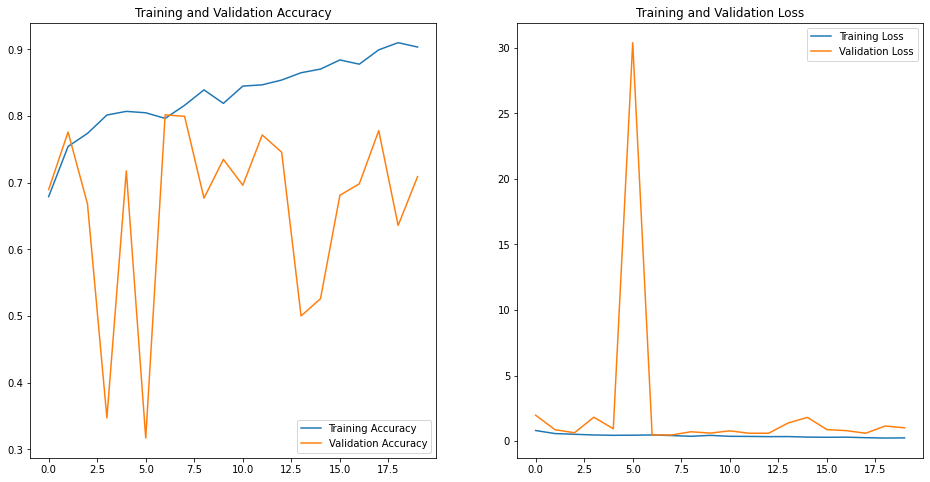

In [104]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
from tensorflow.keras.models import load_model
model = load_model('C:/Users/s_wnsgk4041/cal/2-2_vgg16/07-0.4734.hdf5')



# model.summary()

In [35]:
scores = model.evaluate_generator(test_generator)

print("\n%s: %.2f" % (model.metrics_names[0], scores[0]))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

C:\Users\s_wnsgk4041\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



loss: 1.83

accuracy: 42.63%
